# ZCB under Vasicek (Analytical, Simulation, Quadrature)

The price of a zero-coupon-bond is just the discounted value of the par value (as there are no coupons).
Spot rate is the yield-to-maturity on a zero-coupon bond. The basic formula is $B(t,T) =  \frac{M}{{(1 + i)^n} }$.

However, it is also equivalent to finding the average discount factor where discount factor = $ \frac{1}{{(1 + i)^n} }$. Therefore, $B(t,T) = E[e^{-\int_t^Tr_s ds}]$, which is the expectation taken under the risk neutral measure.
* See [this](https://www.youtube.com/watch?v=xZ69KEg7ccU&list=PLNzUmdzNFUET9Itx-RpjDpZXuuusCXxHr&index=5&t=1s) link to know more about measure theory

## Vasicek model to price ZCBs

The Vasicek model is given as $dr_t = \alpha(b-r_t)dt + \sigma dW_t, r_0=r(0)$

Under Vasicek model, the above formula is given as:<br>
$ B(t,T) = e^{-A(t,T)r_t + D(t,T)}$ 

where<br>
$A(t,T) = \frac{1-e^{-\alpha(T-t)}}{\alpha}$ <br>
$D(t,T) = (b - \frac{\sigma^2}{2 \alpha^2})[A(t,T) - (T-t)] - \frac{\sigma^2 A(t,T)^2}{4 \alpha}$

This is the closed form solution (analytical solution) for the bond prices under the Vasicek model.

In [6]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import random

In [31]:
# Parameters
r0 = 0.02
alpha = 0.2
b = 0.05
sigma = 0.025

In [32]:
#mean under the Vasicek model
def vasi_mean(r, t1, t2):
    return np.exp(-alpha*(t2-t1))*r+b*(1-np.exp(-alpha*(t2-t1)))

#variance under the Vasicek model
def vasi_var(t1,t2):
    return (sigma**2)*(1-np.exp(-2*alpha*(t2-t1)))/(2*alpha)

In [33]:
# Analytical Bond prices under the Vasicek model
def A(t1, t2):
    return (1-np.exp(-alpha*(t2-t1)))/alpha

def D(t1, t2):
    val_1 = (t2-t1-A(t1,t2))*(sigma**2/(2*alpha**2)-b)
    val_2 = sigma**2*A(t1,t2)**2/(4*alpha)
    return val_1 - val_2

def bond_price(r,t,T):
    return np.exp(-A(t,T)*r + D(t,T))

## Joint simulation

We will be jointly simulating two things
- short term rate, $r_t$
- the value $\int_0^t r_s ds$, which will be denoted as $Y_t$

Both will have a jointly gaussian distribution, as we are assuming that the short term rate $r_t$ is normally distributed

$r_t \sim N(r(0)e^{-\alpha t} + b(1-e^{- \alpha t}), \frac{\sigma^2}{2 \alpha}(1 - e^{- 2\alpha t}))$
<br>
$Y_{t_2} \sim N(Y_{t_1} + (t_2 - t_1)b + (r_{t_1} - b)A(t_1, t_2), \frac{\sigma^2}{\alpha^2}(t_2 - t_1 - A(t_1, t_2) - \alpha \frac{A(t_1, t_2)^2}{2}) )$


where, <br>
Covariance $Y_{t_2}, r_{t_2}$ = $\frac{\sigma^2  A(t_1, t_2)^2}{2}$<br>

The price of the bond will be found using this formula: <br>
    $B(0,t) = E[e^{- \int_0^t r_s ds}] = E[e^{-Y_t}]$ 

In [34]:
## calculates the mean for Yt2 given Yt1 and rt1, where t1 < t2
def Y_mean(Y, r, t1, t2):
    return Y + (t2-t1)*b+(r-b)*A(t1,t2)

## calculates the variance for Yt2
def Y_var(t1,t2):
    return sigma**2*(t2-t1-A(t1,t2)**2/2)/(alpha**2)

## covariance bewteen yt2 and rt2
def rY_var(t1, t2):
    return sigma**2*2*(A(t1,t2)**2)/2
   
## correlation from the covariance
def rY_rho(t1, t2):
    return rY_var(t1,t2)/np.sqrt(vasi_var(t1,t2)*Y_var(t1,t2))

In [35]:
# Initial Y Value
Y0 = 0

np.random.seed(0)

# number of years simulated and number of simulations
n_years = 10
n_simulations = 100000

# array of number of years
# creates integers, which is okay since we are simulating on an annual basis
t = np.array(range(0,n_years+1))

# standard normal matrices for rt and Yt
Z_mont1 = norm.rvs(size= [n_simulations, n_years])
Z_mont2 = norm.rvs(size= [n_simulations, n_years])
r_simtemp = np.zeros([n_simulations, n_years+1])
Y_simtemp = np.zeros([n_simulations, n_years+1])

# Set the first column (the initial value of each simulation) to r(0) and Y(0)
r_simtemp[:,0] = r0
Y_simtemp[:,0] = Y0

# Creating correlated standard normals
correlations = rY_rho(t[0:-1], t[1:]) # 0 to last, from t to all
Z_mont2 = correlations*Z_mont1 + np.sqrt(1-correlations**2)*Z_mont2

# run simulation
for i in range(n_years):
    # generate the rt and yt paths
    r_simtemp[:, i+1] = vasi_mean(r_simtemp[:,i], t[i], t[i+1]) + np.sqrt(vasi_var(t[i], t[i+1]))*Z_mont1[:,i]
    Y_simtemp[:, i+1] = Y_mean(Y_simtemp[:,i], r_simtemp[:,i], t[i], t[i+1]) + np.sqrt(Y_var(t[i], t[i+1]))*Z_mont2[:,i]

# Estimate bond prices using Monte Carlo by taking the mean bond prices for each year over all simulations
ZCB_prices = np.mean(np.exp(-Y_simtemp), axis=0)

In [36]:
mont_yield = -np.log(ZCB_prices[1:])/t[1:]

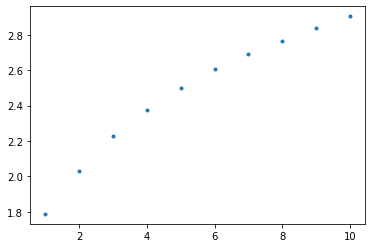

In [37]:
plt.plot(t[1:], mont_yield*100, ".", label="Joint Simulation")

## Quadrature approach

This approach is computationally better. Here, instead of simulating two variables, we only simulate the $r_t$.

$ y_t = \int_0^t r_s ds $ <br>
$\approx \Sigma_{i=0}^{n-1}r_{t_i}\delta_i$ <br>
$\approx \sum_{i=0}^{n=1} \frac{r_{t_i} + r_{t_{i+1}}}{2}\delta_i $

where, <br>
$\mathcal{O} = t_0 < t_1 < t_2 < ... < t_n = t$<br>
$\delta_i = t_{i+1}-t_i$

This falls in the category of a quadrature as the second approximation has a $\mathcal{O}(\delta^2)$ error whereas the first approximation has a $\mathcal{O}(\delta)$ error.

Note: $\mathcal{O}$ is not zero or the letter O, it is "Big O"

In [17]:
# Y_t estimates using the approximations
r_mat = np.cumsum(r_simtemp[:,0:-1], axis=1)*(t[1:] - t[0:-1])
r_mat2 = np.cumsum(r_simtemp[:,0:-1] + r_simtemp[:,1:], axis=1)/2*(t[1:] - t[0:-1])

# Bond Pirce Estimates
## at time 0, bonds have a price of 1
squad_prices = np.ones(n_years+1)
trap_prices = np.ones(n_years+1)

# find the means replacing Yt with r_mat
squad_prices[1:] = np.mean(np.exp(-r_mat), axis=0)
trap_prices[1:] = np.mean(np.exp(-r_mat2), axis=0)

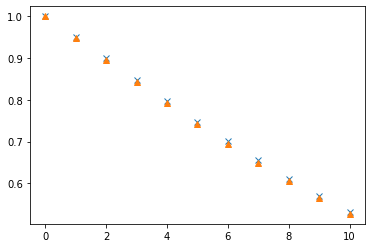

In [25]:
# Simulated rt and estimated Yt
plt.plot(t, squad_prices, "x", label="Simple Quadrature")
# Simulated rt and estimated Yt
plt.plot(t, trap_prices, "^", label="Trapezoidal Quadrature")

## Analtyical

In [29]:
## Analytical: Closed-form bond prices
bond_vec = bond_price(r0,0,t)

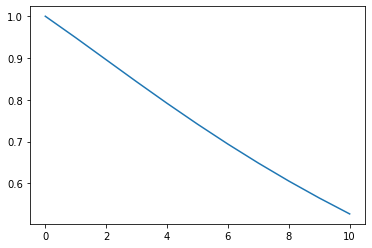

In [30]:
plt.plot(t,bond_vec, label="Closed-Form")

## Plotting: all prices and yields

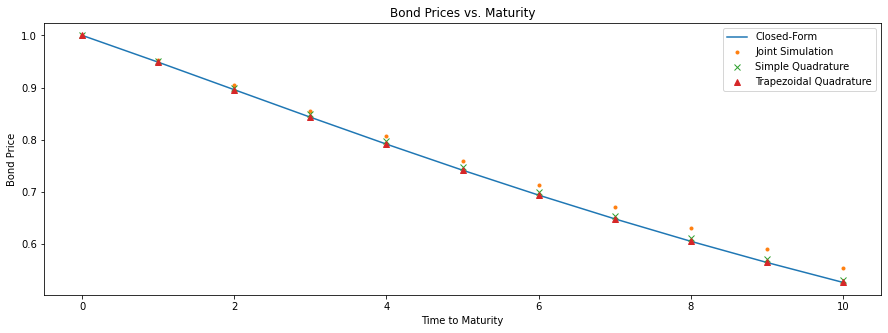

In [22]:
# plotting bond prices
plt.figure(figsize=(15,5))

## Analytical Solution
plt.plot(t,bond_vec, label="Closed-Form")

## Simulated Yt and rt
plt.plot(t, ZCB_prices, ".", label="Joint Simulation")

# Simulated rt and estimated Yt
plt.plot(t, squad_prices, "x", label="Simple Quadrature")
# Simulated rt and estimated Yt
plt.plot(t, trap_prices, "^", label="Trapezoidal Quadrature")

plt.title("Bond Prices vs. Maturity")
plt.xlabel("Time to Maturity")
plt.ylabel("Bond Price")
plt.legend()
plt.show()

In [23]:
# Determining yields
bond_yield = -np.log(bond_vec[1:])/t[1:]
mont_yield = -np.log(ZCB_prices[1:])/t[1:]
squad_yield = -np.log(squad_prices[1:])/t[1:]
trap_yield = -np.log(trap_prices[1:])/t[1:]

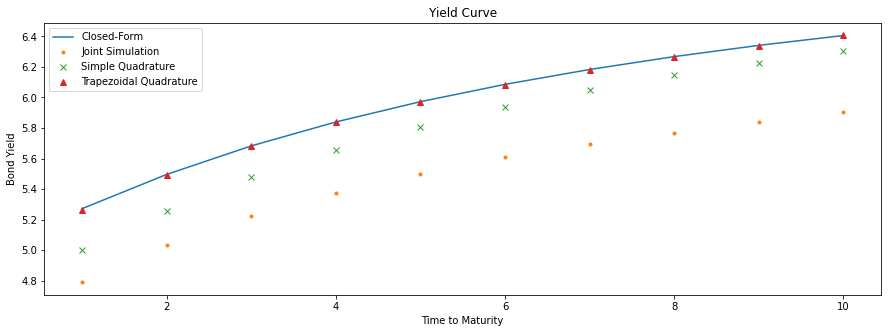

In [24]:
# Plotting the yields
plt.figure(figsize=(15,5))
plt.plot(t[1:], bond_yield*100, label="Closed-Form")
plt.plot(t[1:], mont_yield*100, ".", label="Joint Simulation")
plt.plot(t[1:], squad_yield*100, "x", label="Simple Quadrature")
plt.plot(t[1:], trap_yield*100, "^", label="Trapezoidal Quadrature")
plt.title("Yield Curve")
plt.xlabel("Time to Maturity")
plt.ylabel("Bond Yield")
plt.legend()
plt.show()

Note, that even though here we are using the Vasicek model to model the interest rates, this same technique can be very easily applied to more complex models. 

## Related links
* [STIR models Part 1 (Vasicek and other processes)](<https://github.com/raghavduseja/Fixed-Income/blob/28294c2a62200986a648d759b517690203350880/STIRs/STIR%20models%20Part%201%20(Vasicek%20and%20other%20processes).ipynb>)

## References
* Gianluca Fusai, "Chapter 6: Quadrature Methods", https://sites.google.com/uniupo.it/implementingmodels/implementing-models-in-quantitative-finance/part-1-methods/chapter-6-quadrature-methods
* WQU Notes, Computational Finance